In [1]:
import torch, sys, os, random, json
import matplotlib.pyplot as plt
import numpy as np

from dataset import *
from scipy.ndimage import zoom
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from neuralop.models import TFNO
from neuralop.utils import count_params
from scipy.io import savemat, loadmat
from tqdm import tqdm

# %matplotlib widget

## TOF-SS plot

In [2]:
epoch = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
data_path = '/home/sci/hdai/Projects/Datasets/Ultrasound/GRF/mats'
config = 'noise0'
correlation_list = ['low', 'high']
dataset_type_list = ['training', 'testing']
model_dict = {}

modes, hc, pc = 64, 32, 32
for correlation in correlation_list:
    model_dict[f'tfno_{correlation}'] = TFNO(n_modes=(modes, modes), 
                                         hidden_channels=hc, 
                                         projection_channels=pc, 
                                         factorization='tucker', rank=0.42)
    tfno_checkpoint = torch.load(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/tfno_mode{modes}_hc{hc}_pc{pc}_grf128_{correlation}_{config}/epoch_{epoch}_checkpoints.pth.tar')
    model_dict[f'tfno_{correlation}'].load_state_dict(tfno_checkpoint['model_state_dict'])
    model_dict[f'tfno_{correlation}'] = model_dict[f'tfno_{correlation}'].to(device)

    init_features = 32
    model_dict[f'unet_{correlation}'] = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 
                           'unet', in_channels=3, out_channels=1, 
                           init_features=init_features, pretrained=False)
    unet_checkpoint = torch.load(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/unet_{init_features}_grf128_{correlation}_{config}/epoch_{epoch}_checkpoints.pth.tar')
    model_dict[f'unet_{correlation}'].load_state_dict(unet_checkpoint['model_state_dict'])
    model_dict[f'unet_{correlation}'] = model_dict[f'unet_{correlation}'].to(device)
    
with open(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/training_subset_id_list.json', "rb") as fp:
    training_subset_id_list = json.load(fp)
with open(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/testing_subset_id_list.json', "rb") as fp:
    testing_subset_id_list = json.load(fp)

dataloader_dict = {}
dataset_dict = {}
subset_idx_dict = {'low_training': [197], 'low_testing': [12], 'high_training': [37], 'high_testing': [112]}

for correlation in correlation_list:
    for dataset_type in dataset_type_list:
        dataset_dict[f'{correlation}_{dataset_type}'] = PairDataset(data_path, config=config, correlation=correlation, subset_idx_list=subset_idx_dict[f'{correlation}_{dataset_type}'])
        dataloader_dict[f'{correlation}_{dataset_type}'] = DataLoader(dataset_dict[f'{correlation}_{dataset_type}'], batch_size=1, shuffle=False, num_workers=0)

Using cache found in /home/sci/hdai/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/sci/hdai/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


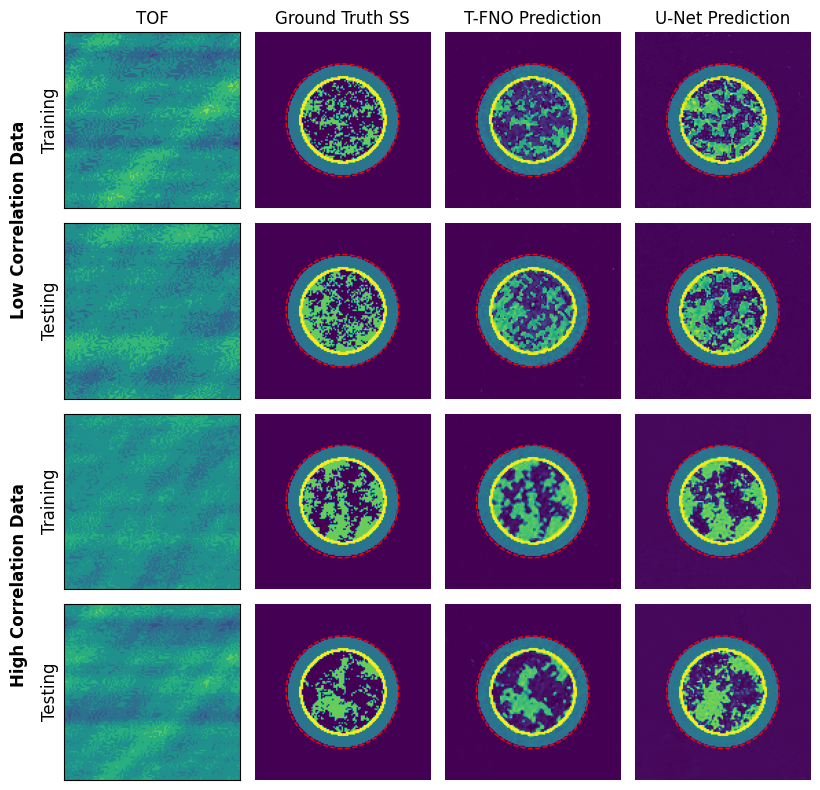

In [71]:
colormap = 'viridis'
circle_list = []
ax_list = []
im_list = []
row, col = 4, 4
for i in range(16):
    circle_list.append(plt.Circle((63.5, 63.5), 41, color='r', fill=False, linestyle='--'))
fig = plt.figure(figsize=(8, 8))
correlation_list = ['low', 'high']
dataset_type_list = ['training', 'testing']

'''low correlation training sample'''
# plt.text(1, 1, 'boxed italics text in data coords')
for i in range(len(correlation_list)):
    for j in range(len(dataset_type_list)):
        plot_row_num = (i*2+j)*4
        data = dataloader_dict[f'{correlation_list[i]}_{dataset_type_list[j]}'].dataset[0]
        x = data['input'].to(device)
        y = data['output'].to(device)
        tfno_out = model_dict[f'tfno_{correlation_list[i]}'](x.unsqueeze(0))
        unet_out = model_dict[f'unet_{correlation_list[i]}'](x.unsqueeze(0))

        ax_list.append(fig.add_subplot(row, col, plot_row_num+1))
        ax_list[plot_row_num].imshow(x[0].to('cpu'), cmap=colormap, vmin=0, vmax=1)
        if plot_row_num==0:
            ax_list[plot_row_num].set_title('TOF', fontsize=12)
        plt.ylabel(f'{dataset_type_list[j].capitalize()}', fontsize=12) # {correlation_list[i]} correlation\n 
        ax_list[plot_row_num].set_xticks([])
        ax_list[plot_row_num].set_yticks([])

        ax_list.append(fig.add_subplot(row, col, plot_row_num+2))
        ax_list[plot_row_num+1].imshow(y.to('cpu').squeeze(), cmap=colormap, vmin=0, vmax=1)
        ax_list[plot_row_num+1].add_patch(circle_list[plot_row_num+1])
        if plot_row_num==0:
            ax_list[plot_row_num+1].set_title('Ground Truth SS', fontsize=12)
        plt.axis('off')

        ax_list.append(fig.add_subplot(row, col, plot_row_num+3))
        ax_list[plot_row_num+2].imshow(tfno_out.to('cpu').squeeze().detach().numpy(), cmap=colormap, vmin=0, vmax=1)
        ax_list[plot_row_num+2].add_patch(circle_list[plot_row_num+2])
        if plot_row_num==0:
            ax_list[plot_row_num+2].set_title('T-FNO Prediction', fontsize=12)
        plt.axis('off')

        ax_list.append(fig.add_subplot(row, col, plot_row_num+4))
        ax_list[plot_row_num+3].imshow(unet_out.to('cpu').squeeze().detach().numpy(), cmap=colormap, vmin=0, vmax=1)
        ax_list[plot_row_num+3].add_patch(circle_list[plot_row_num+3])
        if plot_row_num==0:
            ax_list[plot_row_num+3].set_title('U-Net Prediction', fontsize=12)
        plt.axis('off')

plt.figtext(-0.02, 0.60, 'Low Correlation Data', rotation=90, fontsize=12, weight='bold') 
plt.figtext(-0.02, 0.14, 'High Correlation Data', rotation=90, fontsize=12, weight='bold') 
plt.tight_layout()
plt.savefig(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/paper_plot_{config}.pdf', dpi=300, bbox_inches = 'tight')

## Loss plot

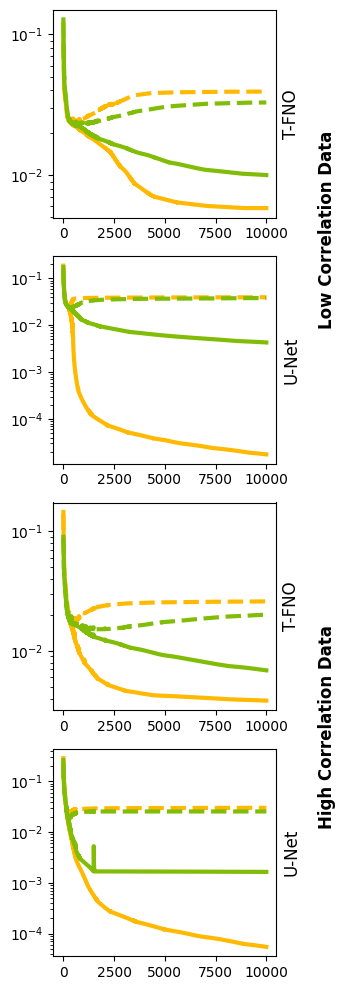

In [72]:
config = 'noise0'
loss_trend_dict = {}
color_dict = {'big': '#81bc06', 'small': '#ffb901'}
line_style_dict = {'training': '-', 'testing': '--'}
disp_name_dict = {'tfno': 'T-FNO', 'unet': 'U-Net'}

for dataset_type in ['training', 'testing']:
    for correlation in ['low', 'high']:
        for dateset_size in ['small', 'big']:
            with open(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_{dateset_size}/unet_{init_features}_grf128_{correlation}_{config}/{dataset_type}_loss.json', "rb") as fp:
                loss_trend_dict[f'unet_{dataset_type}_loss_list_{dateset_size}_{correlation}'] = json.load(fp)
            with open(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_{dateset_size}/tfno_mode{modes}_hc{hc}_pc{pc}_grf128_{correlation}_{config}/{dataset_type}_loss.json', "rb") as fp:
                loss_trend_dict[f'tfno_{dataset_type}_loss_list_{dateset_size}_{correlation}'] = json.load(fp)
                
fig = plt.figure(figsize=(3.2,10))
ax_list = []
i = 0
for correlation in ['low', 'high']:
    for model_type in ['tfno', 'unet']:
        ax_list.append(fig.add_subplot(4, 1, i+1))
        ax_list[i].set_ylabel(f'{disp_name_dict[model_type]}', fontsize=12)#{correlation} correlation\n 
        ax_list[i].set_yscale('log')
        ax_list[i].yaxis.set_label_position("right")
        for dateset_size in ['small', 'big']:
            for dataset_type in ['training', 'testing']:
                ax_list[i].plot(loss_trend_dict[f'{model_type}_{dataset_type}_loss_list_{dateset_size}_{correlation}'],
                                color=color_dict[dateset_size],
                                linewidth=3,
                                linestyle=line_style_dict[dataset_type])
        i += 1

plt.figtext(1.01, 0.67, 'Low Correlation Data', rotation=90, fontsize=12, weight='bold') 
plt.figtext(1.01, 0.17, 'High Correlation Data', rotation=90, fontsize=12, weight='bold') 
plt.tight_layout()
plt.savefig(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/horizontal_loss_plot_{config}.pdf', dpi=300, bbox_inches = 'tight')

## Colorbar

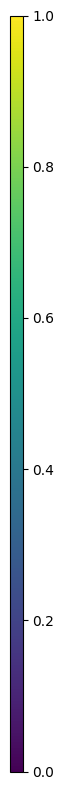

In [32]:
fig = plt.figure(figsize=(2, 8))
plt.imshow(x[0].to('cpu'), cmap=colormap, vmin=0, vmax=1)
plt.gca().set_visible(False)
plt.colorbar(aspect=60)
plt.tight_layout()
plt.savefig(f'/home/sci/hdai/Projects/UltrasoundTfno/Checkpoints_big/colorbar.pdf', dpi=300)

Text(0, 0.5, 'sdfsd')

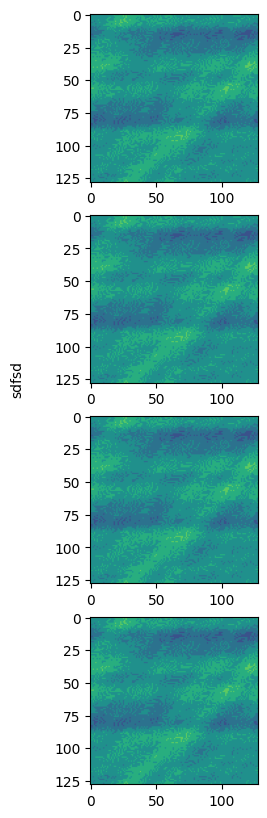

In [43]:

fig = plt.figure(figsize=(3.2,10))
ax1 = fig.add_subplot(4, 1, 1)
ax1.imshow(x[0].to('cpu'), cmap=colormap, vmin=0, vmax=1)
ax2 = fig.add_subplot(4, 1, 2)
ax2.imshow(x[0].to('cpu'), cmap=colormap, vmin=0, vmax=1)
ax3 = fig.add_subplot(4, 1, 3)
ax3.imshow(x[0].to('cpu'), cmap=colormap, vmin=0, vmax=1)
ax4 = fig.add_subplot(4, 1, 4)
ax4.imshow(x[0].to('cpu'), cmap=colormap, vmin=0, vmax=1)
plt.figtext(0,0.5,'sdfsd',rotation=90, ) 